# CIV1498 Project 2

## Predict MVP

Firstly, a logistic regression model is trained with pitching and batting datasets to predict a group of top players. </br>
Secondly, a linear regression model is applied to predict MVP voting scores and rank players.</br>
Thirdly, the players' rank from the model is compared with the MVP list.

In [4]:
# Import 3rd party libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Configure Notebook
%matplotlib inline
plt.style.use('fivethirtyeight')
sns.set_context("notebook")
import warnings
warnings.filterwarnings('ignore')

## The Data

In [5]:
# Combine annual csv files
MLB_players = pd.concat(map(pd.read_csv, ['2008_complete.csv','2009_complete.csv','2010_complete.csv',
                                          '2011_complete.csv','2012_complete.csv','2013_complete.csv',
                                          '2014_complete.csv','2015_complete.csv','2016_complete.csv', 
                                          '2017_complete.csv','2018_complete.csv','2019_complete.csv', 
                                          '2020_complete.csv','2021_complete.csv']), ignore_index=True)
MLB_players = MLB_players.iloc[: , 1:]
MLB_players

,full_name,player_id,year,player_age,league,rank,vote_points,1st_place,mvp_share,Total_WAR,...,b_triple,b_home_run,b_strikeout,b_walk,b_k_percent,b_bb_percent,batting_avg,slg_percent,on_base_percent,on_base_plus_slg
0,Albert Pujols,405395.0,2008,28,NL,1.0,369.0,18.0,0.82,9.24,...,0,37,54,104,8.4,16.2,0.357,0.653,0.462,1.114
1,Chase Utley,400284.0,2008,30,NL,14.0,30.0,0.0,0.07,9.04,...,4,33,104,64,14.7,9.1,0.292,0.535,0.379,0.914
2,Tim Lincecum,453311.0,2008,24,NL,23.0,9.0,0.0,0.02,8.00,...,1,0,32,5,39.5,6.2,0.157,0.200,0.198,0.398
3,Nick Markakis,455976.0,2008,25,AL,0.0,0.0,0.0,0.00,7.43,...,1,20,113,99,16.2,14.2,0.306,0.491,0.406,0.897
4,Chipper Jones,116706.0,2008,36,NL,12.0,44.0,0.0,0.10,7.33,...,1,22,61,90,11.4,16.9,0.364,0.574,0.470,1.044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9687,Cody Bellinger,641355.0,2021,26,NL,0.0,0.0,0.0,0.00,-1.54,...,2,10,94,31,26.9,8.9,0.165,0.302,0.240,0.542
9688,Maikel Franco,596748.0,2021,29,AL,0.0,0.0,0.0,0.00,-1.56,...,0,11,67,20,16.6,5.0,0.210,0.355,0.253,0.609
9689,Jarred Kelenic,672284.0,2021,22,AL,0.0,0.0,0.0,0.00,-1.80,...,1,14,106,36,28.1,9.5,0.181,0.350,0.265,0.615
9690,Pat Valaika,642162.0,2021,29,AL,0.0,0.0,0.0,0.00,-1.86,...,0,5,76,16,27.0,5.7,0.201,0.290,0.249,0.539


# Train/Test split

In [6]:
# add a label for top players if they were voted as MVP candidates.
MLB_players['Top_players'] = MLB_players['vote_points'].apply(lambda x: 1 if x > 0 else 0)
MLB_players.head(5)

,full_name,player_id,year,player_age,league,rank,vote_points,1st_place,mvp_share,Total_WAR,...,b_home_run,b_strikeout,b_walk,b_k_percent,b_bb_percent,batting_avg,slg_percent,on_base_percent,on_base_plus_slg,Top_players
0,Albert Pujols,405395.0,2008,28,NL,1.0,369.0,18.0,0.82,9.24,...,37,54,104,8.4,16.2,0.357,0.653,0.462,1.114,1
1,Chase Utley,400284.0,2008,30,NL,14.0,30.0,0.0,0.07,9.04,...,33,104,64,14.7,9.1,0.292,0.535,0.379,0.914,1
2,Tim Lincecum,453311.0,2008,24,NL,23.0,9.0,0.0,0.02,8.00,...,0,32,5,39.5,6.2,0.157,0.200,0.198,0.398,1
3,Nick Markakis,455976.0,2008,25,AL,0.0,0.0,0.0,0.00,7.43,...,20,113,99,16.2,14.2,0.306,0.491,0.406,0.897,0
4,Chipper Jones,116706.0,2008,36,NL,12.0,44.0,0.0,0.10,7.33,...,22,61,90,11.4,16.9,0.364,0.574,0.470,1.044,1


In [7]:
# Split data between train data (2018 or sooner) and test data (after 2018)
train_top = MLB_players[MLB_players['year'] <= 2018]
test_top = MLB_players[MLB_players['year'] > 2018]

# Check train-test split and proportions of top players
print('Train:', train_top.shape, 'Test:', test_top.shape)
print('Test/Train: {:.2f} %'.format(test_top.shape[0]/train_top.shape[0]*100))
print('Train Top players proportion: {:.2f} %'.format(train_top['Top_players'][train_top['Top_players'] == 1].shape[0] / train_top.shape[0] * 100))
print('Test Top players proportion: {:.2f} %'.format(test_top['Top_players'][test_top['Top_players'] == 1].shape[0] / test_top.shape[0] * 100))

Train: (7726, 28) Test: (1966, 28)
Test/Train: 25.45 %
Train Top players proportion: 6.10 %
Test Top players proportion: 6.05 %


# Annual data standardize

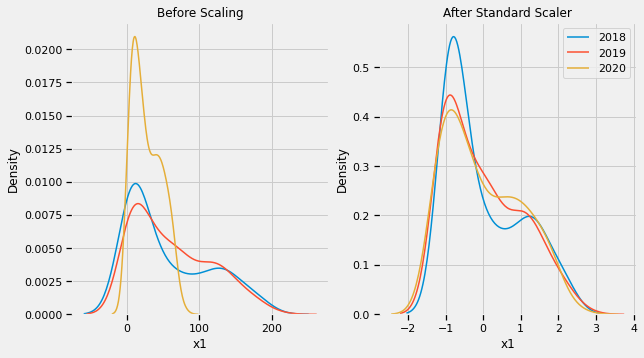

In [8]:
# Visualize the effects of standardization using 2018-2020 total hits

import random
from sklearn import preprocessing

# Randomly sample 200 datapoints (b_total_hits stats) from each year
np.random.seed(1)
df = pd.DataFrame({
    'x1': random.sample(MLB_players[MLB_players['year'] == 2018].b_total_hits.tolist(), 200),
    'x2': random.sample(MLB_players[MLB_players['year'] == 2019].b_total_hits.tolist(), 200),
    'x3': random.sample(MLB_players[MLB_players['year'] == 2020].b_total_hits.tolist(), 200)
})

# Fit scaler to randomly-sampled datapoints
scaler = preprocessing.StandardScaler()
scaled_df = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_df, columns=['x1', 'x2', 'x3'])

# Plot
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(9, 5))

ax1.set_title('Before Scaling')
sns.kdeplot(df['x1'], ax=ax1)
sns.kdeplot(df['x2'], ax=ax1)
sns.kdeplot(df['x3'], ax=ax1)
ax2.set_title('After Standard Scaler')
sns.kdeplot(scaled_df['x1'], ax=ax2 , label="2018")
sns.kdeplot(scaled_df['x2'], ax=ax2 , label="2019")
sns.kdeplot(scaled_df['x3'], ax=ax2 , label="2020")

ax2.legend()
plt.show()

In [9]:
# Standardize features to be used in modelling
from sklearn.preprocessing import StandardScaler

# Define numerical features to use for modelling
num_features = ['player_age', 'WAR_bat', 'WAR_pit', 'b_ab', 'b_total_pa', 'b_total_hits', 'b_single', 'b_double', 'b_triple', 
                'b_home_run', 'b_strikeout', 'b_walk', 'batting_avg', 'slg_percent', 'on_base_percent']

# Define categorical features to use for modelling
cat_features = ['full_name', 'Top_players' , 'year' , 'league' , 'vote_points', 'rank']


# Fit scaler (get the mean and stdev) for the data
def Annual_scaler(df):
    
    x=[]
    for year in df.year.unique():
        scaler = StandardScaler()
        scaler.fit(df[[feat for feat in num_features if feat in df.columns]][df['year'] == year])
    
        scaled = df[[feat for feat in num_features if feat in df.columns]][df['year']== year].copy()
        scaled.iloc[:, :] = scaler.transform(scaled)
        x.append(scaled)

    return pd.concat(x)


# Return all features with numerical features standardized
def create_features(df):
    """Create a feature set from taxi ride dataframe df."""
    
    scaled = df[[feat for feat in num_features if feat in df.columns]].copy()
    
    # Convert numeric features to standard units
    df_scaled = Annual_scaler(df).reset_index()
    
    # Convert categorical features
    categoricals = df[[feat for feat in cat_features if feat in df.columns]].copy().reset_index()
    
    return pd.concat([categoricals , df_scaled], axis=1).drop(columns = ['index'])

# Let's test our function
create_features(train_top)

,full_name,Top_players,year,league,vote_points,rank,player_age,WAR_bat,WAR_pit,b_ab,...,b_total_hits,b_single,b_double,b_triple,b_home_run,b_strikeout,b_walk,batting_avg,slg_percent,on_base_percent
0,Albert Pujols,1,2008,NL,369.0,1.0,-0.217101,5.109845,-0.233875,1.453479,...,2.159566,1.706994,2.461658,-0.629517,3.291913,0.210168,3.338196,1.777088,2.287802,2.004983
1,Chase Utley,1,2008,NL,30.0,14.0,0.245093,4.988241,-0.233875,1.867949,...,1.987364,1.523502,2.226214,1.392912,2.855430,1.480766,1.691336,0.856612,1.398661,1.040007
2,Tim Lincecum,1,2008,NL,9.0,23.0,-1.141490,-0.398837,7.858099,-0.813622,...,-0.871200,-0.835683,-0.913035,-0.123909,-0.745556,-0.348896,-0.737782,-1.055147,-1.125594,-1.064340
3,Nick Markakis,0,2008,AL,0.0,0.0,-0.910393,4.009325,-0.233875,1.808026,...,2.073465,1.890487,2.775582,-0.123909,1.436860,1.709474,3.132339,1.054868,1.067117,1.353915
4,Chipper Jones,1,2008,NL,44.0,12.0,1.631677,3.948523,-0.233875,1.029022,...,1.694619,1.890487,0.892033,-0.123909,1.655101,0.388051,2.761795,1.876216,1.692530,2.097993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7721,Homer Bailey,0,2018,NL,0.0,0.0,0.982247,-0.528404,-1.796854,-1.022566,...,-0.985675,-0.959128,-0.963402,-0.626616,-0.819749,-0.937876,-0.878020,-1.378859,-1.652023,-1.808594
7722,Magneuris Sierra,0,2018,NL,0.0,0.0,-1.663658,-1.526259,-0.250906,-0.397741,...,-0.517006,-0.314326,-0.705334,-0.626616,-0.819749,-0.368895,-0.660518,-0.312430,-0.940129,-0.632962
7723,Hunter Dozier,0,2018,AL,0.0,0.0,-0.340705,-1.711047,-0.250906,0.712484,...,0.514067,0.389094,0.671030,1.560298,0.381209,1.162976,0.122490,0.242114,0.424335,0.072417
7724,Alcides Escobar,0,2018,AL,0.0,0.0,0.982247,-1.815761,-0.250906,1.347636,...,1.057724,1.385605,0.929098,1.013569,-0.383037,0.397041,0.339992,0.270552,-0.183741,0.037148


# 2. Linear regression - predict MVP vote points directly

In [10]:
# Get X_train by dropping columns related to MVP voting and string columns
X_train_MVP = create_features(train_top).drop(columns = ['full_name', 'Top_players' , 'year' , 'vote_points', 'rank' , 'Top_players','league'])

# Get y_train by isolating votes received by each player
y_train_MVP = create_features(train_top)['vote_points']

In [11]:
from sklearn.linear_model import LinearRegression
linear_model = LinearRegression(fit_intercept=True)

# Linearly regress vote points based on input features
linear_model.fit(X_train_MVP, y_train_MVP)
y_train_MVP_pred = linear_model.predict(X_train_MVP)

In [12]:
def rmse(errors):
    """Return the root mean squared error."""
    return np.sqrt(np.mean(errors ** 2))

# Get RMSE for linear regression model
train_rmse = rmse(y_train_MVP- y_train_MVP_pred)

# Print score
print('Linear regression model validation RMSE: {0:0.2f} points'.format(train_rmse))

Linear regression model validation RMSE: 25.64 points


## Linear regression - TEST

The top 6 players in the model only have 3 of 4 real MVPs though RMSE is small. 

In [13]:
# Get test X and y features
X_test_MVP = create_features(test_top).drop(columns = ['full_name', 'Top_players' , 'year' , 'vote_points', 'rank' , 'Top_players','league'])
y_test_MVP = create_features(test_top)['vote_points']

# Predict MVPs for test set using linear regression model
y_test_MVP_pred = linear_model.predict(X_test_MVP)

In [14]:
# Calculate test RMSE for linear regression model
test_rmse = rmse(y_test_MVP - y_test_MVP_pred)

# Print score
print('Linear regression model validation RMSE: {0:0.2f} points'.format(test_rmse))

Linear regression model validation RMSE: 26.84 points


In [15]:
# View all players' input features and predicted labels
MVP_linear_pred = pd.concat([test_top.reset_index(), pd.DataFrame(y_test_MVP_pred)], axis=1).rename(columns={0: 'Pred_points'})
MVP_linear_pred.head(5)

,index,full_name,player_id,year,player_age,league,rank,vote_points,1st_place,mvp_share,...,b_strikeout,b_walk,b_k_percent,b_bb_percent,batting_avg,slg_percent,on_base_percent,on_base_plus_slg,Top_players,Pred_points
0,7726,Alex Bregman,608324.0,2019,25,AL,2.0,335.0,13.0,0.80,...,83,119,12.0,17.2,0.296,0.592,0.423,1.015,1,111.055326
1,7727,Cody Bellinger,641355.0,2019,24,NL,1.0,362.0,19.0,0.86,...,108,95,16.3,14.4,0.305,0.629,0.405,1.034,1,108.426290
2,7728,Jacob deGrom,594798.0,2019,31,NL,10.0,44.0,0.0,0.10,...,19,4,27.1,5.7,0.200,0.323,0.243,0.566,1,15.520798
3,7729,Marcus Semien,543760.0,2019,29,AL,3.0,228.0,0.0,0.54,...,102,87,13.7,11.6,0.285,0.522,0.369,0.892,1,74.564003
4,7730,Mike Trout,545361.0,2019,28,AL,1.0,355.0,17.0,0.85,...,120,110,20.0,18.3,0.291,0.645,0.438,1.083,1,104.545146


In [16]:
# View top 5 players (based on predicted vote points) across both leagues
# Note that of the top 5 predicted players, only 2 actually won MVP despite 6 MVPs existing in the test dataset
MVP_linear_pred[['full_name','rank','year','vote_points','Pred_points', 'league']].sort_values(by=['Pred_points'], ascending=False).head(5)

,full_name,rank,year,vote_points,Pred_points,league
723,Freddie Freeman,1.0,2020,410.0,113.615065,NL
1250,Vladimir Guerrero Jr.,2.0,2021,269.0,111.831041,AL
0,Alex Bregman,2.0,2019,335.0,111.055326,AL
1249,Juan Soto,2.0,2021,274.0,110.372209,NL
1,Cody Bellinger,1.0,2019,362.0,108.426290,NL


In [17]:
# View predicted MVP for each year in test dataset
# Again, note that only two predicted MVPs actually won MVP
MVP_linear_pred[['full_name','rank','year','vote_points','Pred_points', 'league']].sort_values(by=['Pred_points'], ascending=False).drop_duplicates(['year','league']).sort_values(by=['year', 'league'], ascending=False)

,full_name,rank,year,vote_points,Pred_points,league
1249,Juan Soto,2.0,2021,274.0,110.372209,NL
1250,Vladimir Guerrero Jr.,2.0,2021,269.0,111.831041,AL
723,Freddie Freeman,1.0,2020,410.0,113.615065,NL
725,DJ LeMahieu,3.0,2020,230.0,89.497057,AL
1,Cody Bellinger,1.0,2019,362.0,108.426290,NL
0,Alex Bregman,2.0,2019,335.0,111.055326,AL


<p> Summary of linear regression results: </p>
<ul>
    <li> Low training RMSE but high test RMSE - indicates overfitting to training data and low overall performance </li>
    <li> Model correctly predicted only 2 true MVP winners </li>
</ul>
<p> Overall: linear regression appears to be a poor fit for our task. </p>

# 3.1 Logistic regression - find top players

In [18]:
# Get X_train by dropping columns related to MVP voting and string columns
X_train_top = create_features(train_top).drop(columns = ['full_name', 'Top_players' , 'year' , 'vote_points', 'rank'  ,'league'])

# Get y_train by isolated top player labels (whether players received MVP votes)
y_train_top = create_features(train_top)['Top_players']

In [19]:
from sklearn.linear_model import LogisticRegression

# Train logistic model
log_model = LogisticRegression(fit_intercept=True)
log_model.fit(X_train_top, y_train_top)

LogisticRegression()

In [20]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV

In [21]:
# Predict top players using logistic regression model
y_train_top_pred = log_model.predict(X_train_top)
y_train_top_pred

array([1, 1, 1, ..., 0, 0, 0])

In [22]:
# Count number of predicted top players and non-top players
pd.DataFrame(y_train_top_pred).value_counts()

0    7316
1     410
dtype: int64

In [23]:
# Get accuracy of logistic model
accuracy_score(y_train_top,y_train_top_pred)

0.973466217965312

In [24]:
# Get confusion matrix of logistic model predictions
cm = confusion_matrix(y_train_top,y_train_top_pred)

print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[1,1])
print('\nTrue Negatives(TN) = ', cm[0,0])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])
TP = cm[1,1]
TN = cm[0,0]
FP = cm[0,1]
FN = cm[1,0]

Confusion matrix

 [[7183   72]
 [ 133  338]]

True Positives(TP) =  338

True Negatives(TN) =  7183

False Positives(FP) =  72

False Negatives(FN) =  133


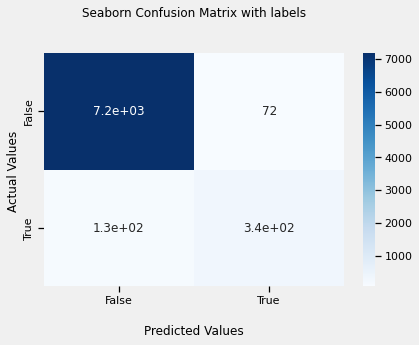

In [25]:
ax = sns.heatmap(cm, annot=True, cmap='Blues')

# Plot confusion matrix
ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
ax.set_ylim(2.0, 0)
## Display the visualization of the Confusion Matrix.
plt.show()

In [26]:
# Calculate precision, recall, and F1 scores
precision = TP / float(TP + FP)
recall = TP / float(TP + FN)
f1 = f1_score(y_train_top,y_train_top_pred,average='macro')

# Display scores
print('Precision : {0:0.4f}'.format(precision))
print('Recall or Sensitivity : {0:0.4f}'.format(recall))
print('f1 : {0:0.4f}'.format(f1))

Precision : 0.8244
Recall or Sensitivity : 0.7176
f1 : 0.8766


## Logistic regression - TEST

In [27]:
# Get X_test and y_test
X_test_top = create_features(test_top).drop(columns = ['full_name', 'Top_players' , 'year' , 'vote_points', 'rank' , 'Top_players','league'])
y_test_top = create_features(test_top)['Top_players']

# Predict labels for the test dataset
y_test_top_pred = log_model.predict(X_test_top)
y_test_top_pred

array([1, 1, 1, ..., 0, 0, 0])

In [28]:
# Count number of predicted top players and non-top players from the test dataset
pd.DataFrame(y_test_top_pred).value_counts()

0    1858
1     108
dtype: int64

In [29]:
# Calculate test accuracy
accuracy_score(y_test_top,y_test_top_pred)

0.9699898270600203

In [30]:
# Get test confusion matrix
cm = confusion_matrix(y_test_top,y_test_top_pred)

print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[1,1])
print('\nTrue Negatives(TN) = ', cm[0,0])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])
TP = cm[1,1]
TN = cm[0,0]
FP = cm[0,1]
FN = cm[1,0]

Confusion matrix

 [[1823   24]
 [  35   84]]

True Positives(TP) =  84

True Negatives(TN) =  1823

False Positives(FP) =  24

False Negatives(FN) =  35


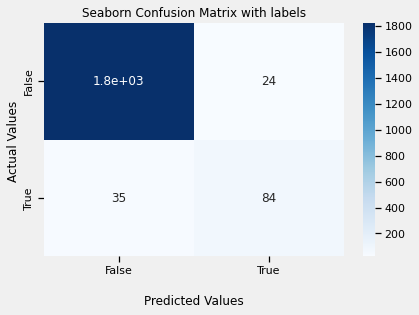

In [31]:
ax = sns.heatmap(cm, annot=True, cmap='Blues')

# Plot test confusion matrix
ax.set_title('Seaborn Confusion Matrix with labels');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
ax.set_ylim(2.0, 0)
## Display the visualization of the Confusion Matrix.
plt.show()

In [32]:
# Calculate test precision, recall, and F1 scores
precision = TP / float(TP + FP)
recall = TP / float(TP + FN)
f1 = f1_score(y_test_top,y_test_top_pred,average='macro')

# Display scores
print('Precision : {0:0.4f}'.format(precision))
print('Recall or Sensitivity : {0:0.4f}'.format(recall))
print('f1 : {0:0.4f}'.format(f1))

Precision : 0.7778
Recall or Sensitivity : 0.7059
f1 : 0.8621


## Logistic regression pipeline

In [98]:
# Given a dataset, names of input features, and name of label column, returns X and y data
def get_top_player_features(data, features, label):
    # Get X_train based on provided input features
    X_data = create_features(data)
    features = [feat for feat in features if feat in X_data.columns]
    X_data = X_data[features]
    # Get y_train by isolating top player labels (whether players received MVP votes)
    y_data = create_features(data)[label]
    return X_data, y_data

    
# Given X and y training data, train a logistic model
def train_top_player_logistic_model(X_train, y_train):
    # Create model and fit to train data
    log_model = LogisticRegression(fit_intercept=True)
    log_model.fit(X_train, y_train)
    #
    return log_model


# Given a logistic model and X, y data, evaluate the model's performance on the provided data
def eval_top_player_logistic_model(model, X_data, y_data):
    # Predict top players using logistic regression model
    y_pred = model.predict(X_data)
    #
    # Count number of predicted top players and non-top players
    print('Predicted numbers of non-top (0) and top (1) players:')
    print(pd.DataFrame(y_pred).value_counts())
    #
    # Get accuracy of logistic model
    accuracy_score(y_data, y_pred)
    #
    # Get confusion matrix of logistic model predictions
    cm = confusion_matrix(y_data, y_pred)
    print('Confusion matrix\n\n', cm)
    print('\tTrue Positives(TP) = ', cm[1,1])
    print('\tTrue Negatives(TN) = ', cm[0,0])
    print('\tFalse Positives(FP) = ', cm[0,1])
    print('\tFalse Negatives(FN) = ', cm[1,0])
    TP = cm[1,1]
    TN = cm[0,0]
    FP = cm[0,1]
    FN = cm[1,0]
    
    precision = TP / float(TP + FP)
    recall = TP / float(TP + FN)
    f1 = f1_score(y_data, y_pred, average='macro')
    #
    # Display scores
    print('Precision : {0:0.4f}'.format(precision))
    print('Recall or Sensitivity : {0:0.4f}'.format(recall))
    print('f1 : {0:0.4f}'.format(f1))
    #
    # Return predictions
    return y_pred

    
# Complete pipeline for training and evaluating a top player logistic regression model
def top_player_logistic_regression_pipeline(train_data, test_data, features, label):
    # Get X_train, y_train
    X_train, y_train = get_top_player_features(train_data, features, label)
    # Train model on train data
    model = train_top_player_logistic_model(X_train, y_train)
    # Evaluate model on train data
    print('EVALUATING ON TRAINING DATA')
    train_pred = eval_top_player_logistic_model(model, X_train, y_train)
    print()
    #
    # Evaluate model on test data
    X_test, y_test = get_top_player_features(test_data, features, label)
    print('EVALUATING ON TESTING DATA')
    test_pred = eval_top_player_logistic_model(model, X_test, y_test)
    print()
    #
    return model, train_pred, test_pred

In [99]:
# Test pipeline

# Get input features
drop_features = ['full_name', 'Top_players' , 'year' , 'vote_points', 'rank'  ,'league']
input_features = [col for col in train_top.columns if not (col in drop_features)]

# Get trained model and predictions
logistic_model, logistic_train_pred, logistic_test_pred = top_player_logistic_regression_pipeline(train_top, test_top, input_features, 'Top_players')

EVALUATING ON TRAINING DATA
Predicted numbers of non-top (0) and top (1) players:
0    7316
1     410
dtype: int64
Confusion matrix

 [[7183   72]
 [ 133  338]]
	True Positives(TP) =  338
	True Negatives(TN) =  7183
	False Positives(FP) =  72
	False Negatives(FN) =  133
Precision : 0.8244
Recall or Sensitivity : 0.7176
f1 : 0.8766

EVALUATING ON TESTING DATA
Predicted numbers of non-top (0) and top (1) players:
0    1858
1     108
dtype: int64
Confusion matrix

 [[1823   24]
 [  35   84]]
	True Positives(TP) =  84
	True Negatives(TN) =  1823
	False Positives(FP) =  24
	False Negatives(FN) =  35
Precision : 0.7778
Recall or Sensitivity : 0.7059
f1 : 0.8621



# 3.2 Linear regression 2 
## Predict MVP vote points from predicted top players


In [35]:
# Prepare the predicted top players dataframe
df = pd.concat([create_features(train_top.reset_index()), pd.DataFrame(y_train_top_pred)], axis=1).rename(columns={0: 'Pred_Top_players'})

# Build a linear model to predict MVPs from top players
X_train_MVP2 = df[df['Pred_Top_players'] == 1].drop(columns = ['full_name', 'Top_players' , 'year' , 'vote_points', 'rank' , 'Pred_Top_players','league'])
y_train_MVP2 = df[df['Pred_Top_players'] == 1]['vote_points']

In [36]:
# Train a linear model to predict MVP votes for top players only
linear_model2 = LinearRegression(fit_intercept=True)

linear_model2.fit(X_train_MVP2, y_train_MVP2)
y_train_MVP_pred2 = linear_model2.predict(X_train_MVP2)

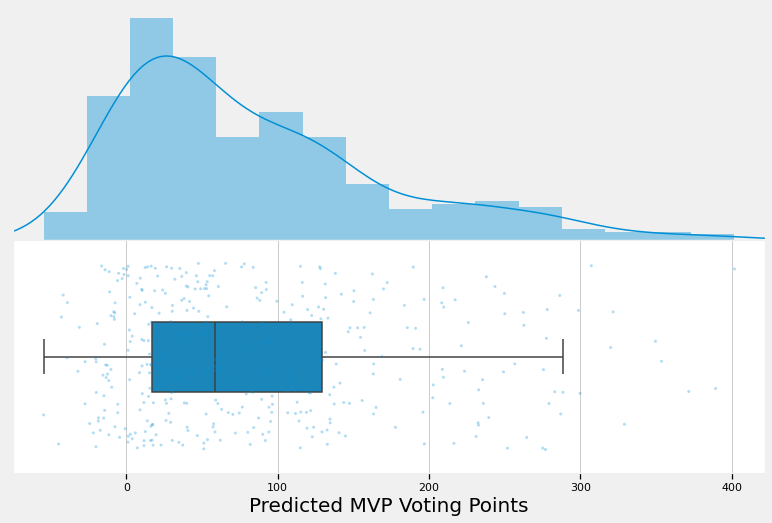

In [37]:
# Examine target variable WAR using three different plot types
fig, axs = plt.subplots(figsize=(12, 8), nrows=2)

sns.distplot(
    y_train_MVP_pred2, 
    ax=axs[0]
)
sns.stripplot(
    y_train_MVP_pred2, 
    jitter=0.4, 
    size=3,
    ax=axs[1],
    alpha=0.3
)
sns.boxplot(
    y_train_MVP_pred2,
    width=0.3, 
    ax=axs[1],
    showfliers=False,
)

# Align axes
spacer = np.max(y_train_MVP_pred2) * 0.05
xmin = np.min(y_train_MVP_pred2) - spacer
xmax = np.max(y_train_MVP_pred2) + spacer
axs[0].set_xlim((xmin, xmax))
axs[1].set_xlim((xmin, xmax))

# Remove some axis text
axs[0].xaxis.set_visible(False)
axs[0].yaxis.set_visible(False)
axs[1].yaxis.set_visible(False)
axs[1].set_xlabel('Predicted MVP Voting Points', fontsize=20)

# Put the two plots together
plt.subplots_adjust(hspace=0)

# Adjust boxplot fill to be white .artists[0]
axs[1].set_facecolor('white')

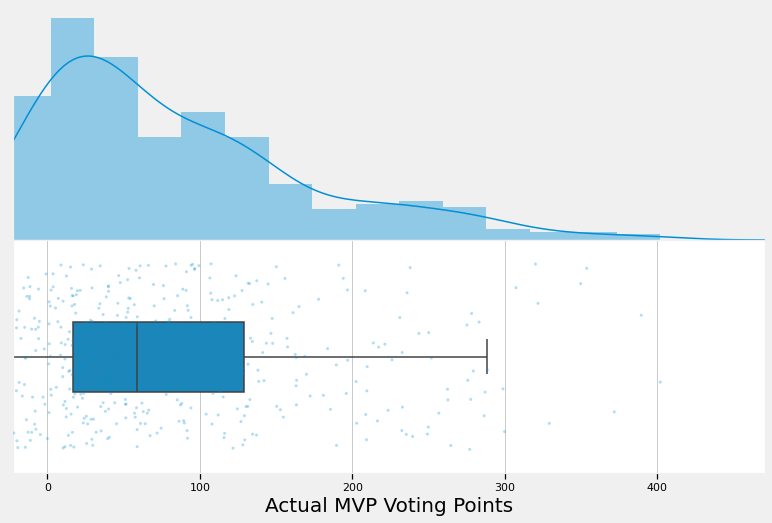

In [38]:
# Examine target variable WAR using three different plot types
fig, axs = plt.subplots(figsize=(12, 8), nrows=2)

sns.distplot(
    y_train_MVP_pred2, 
    ax=axs[0]
)
sns.stripplot(
    y_train_MVP_pred2, 
    jitter=0.4, 
    size=3,
    ax=axs[1],
    alpha=0.3
)
sns.boxplot(
    y_train_MVP_pred2,
    width=0.3, 
    ax=axs[1],
    showfliers=False,
)

# Align axes
spacer = np.max(y_train_MVP) * 0.05
xmin = np.min(y_train_MVP) - spacer
xmax = np.max(y_train_MVP) + spacer
axs[0].set_xlim((xmin, xmax))
axs[1].set_xlim((xmin, xmax))

# Remove some axis text
axs[0].xaxis.set_visible(False)
axs[0].yaxis.set_visible(False)
axs[1].yaxis.set_visible(False)
axs[1].set_xlabel('Actual MVP Voting Points', fontsize=20)

# Put the two plots together
plt.subplots_adjust(hspace=0)

# Adjust boxplot fill to be white .artists[0]
axs[1].set_facecolor('white')

In [39]:
# Calculate train RMSE for top players' MVP vote predictions
train_rmse2 = rmse(y_train_MVP2- y_train_MVP_pred2)
print("The mean squared error (MSE) on train set: {:.4f}".format(train_rmse2))

The mean squared error (MSE) on train set: 63.5172


In [40]:
# Explore the coefficients for each of the independent attributes
 
for idx, col_name in enumerate(X_train_MVP2.columns):
    print("The coefficient for {} is {:.2f}".format(col_name, linear_model2.coef_[idx]))

The coefficient for player_age is -10.06
The coefficient for WAR_bat is 42.80
The coefficient for WAR_pit is 48.12
The coefficient for b_ab is -437.59
The coefficient for b_total_pa is 232.51
The coefficient for b_total_hits is 315.98
The coefficient for b_single is -60.74
The coefficient for b_double is 1.36
The coefficient for b_triple is 7.48
The coefficient for b_home_run is 55.28
The coefficient for b_strikeout is -12.77
The coefficient for b_walk is -13.18
The coefficient for batting_avg is 2.34
The coefficient for slg_percent is -55.16
The coefficient for on_base_percent is 24.78


## Linear regression 2 - TEST
find 3 of 4 MVP in top 5 players

In [41]:
# Prepare the predicted top players dataframe
df = pd.concat([create_features(test_top.reset_index()), pd.DataFrame(y_test_top_pred)], axis=1).rename(columns={0: 'Pred_Top_players'})
df = df[df['Pred_Top_players'] == 1]

# Build a linear model to predict MVPs from top players
X_test_MVP2 = df.drop(columns = ['full_name', 'Top_players' , 'year' , 'vote_points', 'rank' , 'Pred_Top_players','league'])
y_test_MVP2 = df['vote_points']

In [42]:
# Predict top players' MVP votes using the test dataset
y_test_MVP_pred2 = linear_model2.predict(X_test_MVP2)

# Calculate test RMSE (recall: train RMSE was 63.5172)
test_rmse2 = rmse(y_test_MVP2- y_test_MVP_pred2)
print("The mean squared error (MSE) on test set: {:.4f}".format(test_rmse2))

The mean squared error (MSE) on test set: 61.4260


In [43]:
# Display player stats with true and predicted MVP vote points
MVP_linear_pred2 = pd.concat([df.reset_index(), pd.DataFrame(y_test_MVP_pred2)], axis=1).rename(columns={0: 'Pred_points'})
MVP_linear_pred2.head(5)

,index,full_name,Top_players,year,league,vote_points,rank,player_age,WAR_bat,WAR_pit,...,b_double,b_triple,b_home_run,b_strikeout,b_walk,batting_avg,slg_percent,on_base_percent,Pred_Top_players,Pred_points
0,0,Alex Bregman,1,2019,AL,335.0,2.0,-0.862177,4.805955,-0.274132,...,2.183706,0.540041,2.917530,0.542834,4.231692,1.104353,1.614354,1.680921,1,264.649750
1,1,Cody Bellinger,1,2019,NL,362.0,1.0,-1.133652,4.605265,-0.274132,...,1.925622,1.124614,3.468334,1.085938,3.188043,1.229748,1.868904,1.472809,1,272.172178
2,2,Jacob deGrom,1,2019,NL,44.0,10.0,0.766672,-0.146364,8.009164,...,-0.827275,-0.629104,-0.662694,-0.847514,-0.769125,-0.233190,-0.236293,-0.400193,1,57.191576
3,3,Marcus Semien,1,2019,AL,228.0,3.0,0.223722,4.451796,-0.274132,...,2.699874,3.462904,2.183125,0.955593,2.840160,0.951093,1.132773,1.056586,1,168.872305
4,4,Mike Trout,1,2019,AL,355.0,1.0,-0.047752,4.174372,-0.274132,...,1.323426,0.540041,3.284732,1.346629,3.840324,1.034689,1.978980,1.854347,1,202.652846


In [44]:
# Top 5 predicted vote points contain 3 MVPs
league_MVPpred = MVP_linear_pred2[['full_name','rank','year','vote_points','Pred_points','league']].sort_values(by=['Pred_points'], ascending=False)
league_MVPpred.head(5)

,full_name,rank,year,vote_points,Pred_points,league
68,Shohei Ohtani,1.0,2021,420.0,330.498401,AL
44,Freddie Freeman,1.0,2020,410.0,327.100702,NL
73,Vladimir Guerrero Jr.,2.0,2021,269.0,310.349796,AL
50,Marcell Ozuna,6.0,2020,167.0,278.195003,NL
1,Cody Bellinger,1.0,2019,362.0,272.172178,NL


In [45]:
# Predicted annual MVP in each league.
league_MVPpred.drop_duplicates(['year','league']).sort_values(by=['year', 'league'], ascending=False)

,full_name,rank,year,vote_points,Pred_points,league
72,Juan Soto,2.0,2021,274.0,233.465518,NL
68,Shohei Ohtani,1.0,2021,420.0,330.498401,AL
44,Freddie Freeman,1.0,2020,410.0,327.100702,NL
46,DJ LeMahieu,3.0,2020,230.0,219.859114,AL
1,Cody Bellinger,1.0,2019,362.0,272.172178,NL
0,Alex Bregman,2.0,2019,335.0,264.649750,AL


In [46]:
# all of 5 MVPs and their info.
MVP_linear_pred2[MVP_linear_pred2['rank']==1]

,index,full_name,Top_players,year,league,vote_points,rank,player_age,WAR_bat,WAR_pit,...,b_double,b_triple,b_home_run,b_strikeout,b_walk,batting_avg,slg_percent,on_base_percent,Pred_Top_players,Pred_points
1,1,Cody Bellinger,1,2019,NL,362.0,1.0,-1.133652,4.605265,-0.274132,...,1.925622,1.124614,3.468334,1.085938,3.188043,1.229748,1.868904,1.472809,1,272.172178
4,4,Mike Trout,1,2019,AL,355.0,1.0,-0.047752,4.174372,-0.274132,...,1.323426,0.540041,3.284732,1.346629,3.840324,1.034689,1.978980,1.854347,1,202.652846
44,723,Freddie Freeman,1,2020,NL,410.0,1.0,0.726098,3.566534,0.061680,...,4.112961,0.653591,2.055659,0.422799,3.519087,1.767519,2.050412,2.309486,1,327.100702
68,1245,Shohei Ohtani,1,2021,AL,420.0,1.0,-0.434366,2.594339,4.202531,...,1.452681,4.998118,3.848635,2.924387,3.369279,0.670489,1.781339,1.128948,1,330.498401
84,1262,Bryce Harper,1,2021,NL,348.0,1.0,0.115069,3.178130,-0.247176,...,2.960520,0.062586,2.734109,1.710077,3.549929,1.356102,1.941175,1.743882,1,183.915025


## Linear regression pipeline

In [47]:
# Add logistic regression predictions to raw dataset
def join_logistic_pred_to_data(data, pred):
    return pd.concat([create_features(data.reset_index()),
                      pd.DataFrame(pred)
                     ], axis=1
                    ).rename(columns={0: 'Pred_Top_players'})


# Return X, y features for top players only
def isolate_top_players(data):
    return data[data['Pred_Top_players']==1]


# Train linear regression model to predict MVP votes
def train_top_player_linear_model(X_train, y_train):
    lin_model = LinearRegression(fit_intercept=True)
    lin_model.fit(X_train, y_train)
    #
    return lin_model


# Evaluate model on provided data
def eval_top_player_linear_model(model, X_data, y_data, data_type='train'):
    # Get predictions
    y_pred = model.predict(X_data)
    # Calculate RMSE
    data_rmse = rmse(y_data - y_pred)
    print("The mean squared error (MSE) on {} set: {:.4f}".format(data_type, data_rmse))
    #
    return y_pred


# Create training pipeline for linear regression of top players' MVP votes
def top_votes_linear_regression_pipeline(train_data, test_data, train_pred, test_pred, features, label):
    # Add predicted top player labels to train and test data
    train_data_labeled = join_logistic_pred_to_data(train_data, train_pred)
    test_data_labeled = join_logistic_pred_to_data(test_data, test_pred)
    # Get X, y train data
    X_train, y_train = get_top_player_features(isolate_top_players(train_data_labeled), features, label)
    # Train linear model
    model = train_top_player_linear_model(X_train, y_train)
    # Evaluate model on train data
    print('EVALUATING ON TRAINING DATA')
    train_pred = eval_top_player_linear_model(model, X_train, y_train)
    print()
    # Evaluate model on test data
    print('EVALUATING ON TESTING DATA')
    X_test, y_test = get_top_player_features(isolate_top_players(test_data_labeled), features, label)
    test_pred = eval_top_player_linear_model(model, X_test, y_test, data_type='test')
    print()
    #
    #
#     MVP_linear_pred2 = pd.concat([df.reset_index(), pd.DataFrame(y_test_MVP_pred2)], axis=1).rename(columns={0: 'Pred_points'})
#     MVP_linear_pred2.head(5)
    return model, train_pred, test_pred

In [48]:
# Test pipeline

# Get input features
drop_features = ['full_name', 'Top_players' , 'year' , 'vote_points', 'rank' , 'Pred_Top_players','league']
input_features = [col for col in train_top.columns if not (col in drop_features)]

# Get trained model and predictions
linear_model, linear_train_pred, linear_test_pred = top_votes_linear_regression_pipeline(train_top, test_top, 
                                                                                          logistic_train_pred, logistic_test_pred, 
                                                                                          input_features, 'vote_points')

EVALUATING ON TRAINING DATA
The mean squared error (MSE) on train set: 71.1557

EVALUATING ON TESTING DATA
The mean squared error (MSE) on test set: 64.7211



## Logistic+linear regression pipeline

In [49]:
# Evaluate whether MVP winners were correctly predicted
def eval_mvp_prediction(data, top_pred, vote_pred, check_num_players):
    # Join top player and vote predictions to initial dataset
    joined_data = pd.concat([data.reset_index(), pd.DataFrame(top_pred)], axis=1).rename(columns={0: 'Pred_Top_players'})
    joined_data = isolate_top_players(joined_data)
    joined_data = pd.concat([joined_data.reset_index(), pd.DataFrame(vote_pred)], axis=1).rename(columns={0: 'Pred_points'})
    # View players with top predicted votes in each league and year
    mvp_prediction = joined_data[['full_name','rank','year','vote_points','Pred_points','league']].sort_values(by=['Pred_points'], ascending=False)
    mvp_prediction = mvp_prediction.drop_duplicates(['year','league']).sort_values(by=['year', 'league'], ascending=False)
    #
    print(mvp_prediction.head(check_num_players))
    


# Create training pipeline for logistic+linear regression
def logistic_and_linear_pipeline(train_data, test_data, features, 
                                 logistic_label='Top_players', linear_label='vote_points',
                                 check_num_players=6):
    # Carry out logistic regression pipeline
    logistic_model, logistic_train_pred, logistic_test_pred = top_player_logistic_regression_pipeline(train_data, test_data, features, logistic_label)
    # Carry out linear regression pipeline
    linear_model, linear_train_pred, linear_test_pred = top_votes_linear_regression_pipeline(train_data, test_data, 
                                                                                          logistic_train_pred, logistic_test_pred, 
                                                                                          features, linear_label)
    # Evaluate whether MVP winners were correctly predicted
    eval_mvp_prediction(test_data, logistic_test_pred, linear_test_pred, check_num_players)
    # Return logistic and linear models
    return logistic_model, linear_model

In [100]:
# Test full pipeline

# Get input features
drop_features = ['full_name', 'Top_players' , 'year' , 'vote_points', 'rank'  ,'league']
input_features = [col for col in train_top.columns if not (col in drop_features)]

# Train
log_model, lin_model = logistic_and_linear_pipeline(train_top, test_top, input_features, check_num_players=6)

EVALUATING ON TRAINING DATA
Predicted numbers of non-top (0) and top (1) players:
0    7316
1     410
dtype: int64
Confusion matrix

 [[7183   72]
 [ 133  338]]
	True Positives(TP) =  338
	True Negatives(TN) =  7183
	False Positives(FP) =  72
	False Negatives(FN) =  133
Precision : 0.8244
Recall or Sensitivity : 0.7176
f1 : 0.8766

EVALUATING ON TESTING DATA
Predicted numbers of non-top (0) and top (1) players:
0    1858
1     108
dtype: int64
Confusion matrix

 [[1823   24]
 [  35   84]]
	True Positives(TP) =  84
	True Negatives(TN) =  1823
	False Positives(FP) =  24
	False Negatives(FN) =  35
Precision : 0.7778
Recall or Sensitivity : 0.7059
f1 : 0.8621

EVALUATING ON TRAINING DATA
The mean squared error (MSE) on train set: 71.1557

EVALUATING ON TESTING DATA
The mean squared error (MSE) on test set: 64.7211

                full_name  rank  year  vote_points  Pred_points league
72              Juan Soto   2.0  2021        274.0   237.425327     NL
73  Vladimir Guerrero Jr.   2.0  20

# 3.3 Linear regression 3 - reducing modeling features 

In [51]:
# Train model with reduced features
reduced_features = [ 'WAR_bat', 'WAR_pit','batting_avg', 'b_home_run', 'b_total_hits', 'on_base_percent']
red_log_model, red_lin_model = logistic_and_linear_pipeline(train_top, test_top, reduced_features)


EVALUATING ON TRAINING DATA
Predicted numbers of non-top (0) and top (1) players:
0    7330
1     396
dtype: int64
Confusion matrix

 [[7185   70]
 [ 145  326]]

True Positives(TP) =  326

True Negatives(TN) =  7185

False Positives(FP) =  70

False Negatives(FN) =  145
Precision : 0.8232
Recall or Sensitivity : 0.6921
f1 : 0.8686

EVALUATING ON TESTING DATA
Predicted numbers of non-top (0) and top (1) players:
0    1864
1     102
dtype: int64
Confusion matrix

 [[1828   19]
 [  36   83]]

True Positives(TP) =  83

True Negatives(TN) =  1828

False Positives(FP) =  19

False Negatives(FN) =  36
Precision : 0.8137
Recall or Sensitivity : 0.6975
f1 : 0.8682

EVALUATING ON TRAINING DATA
The mean squared error (MSE) on train set: 70.4167

EVALUATING ON TESTING DATA
The mean squared error (MSE) on test set: 68.3968

          full_name  rank  year  vote_points  Pred_points league
67        Juan Soto   2.0  2021        274.0   226.489533     NL
63    Shohei Ohtani   1.0  2021        420.0   

In [52]:
# Explore the coefficients for each of the independent attributes
 
for idx, col_name in enumerate(reduced_features):
    print("The coefficient for {} is {:.2f}".format(col_name, red_lin_model.coef_[idx]))

The coefficient for WAR_bat is 62.90
The coefficient for WAR_pit is 170.38
The coefficient for batting_avg is 5.99
The coefficient for b_home_run is 51.12
The coefficient for b_total_hits is 68.45
The coefficient for on_base_percent is 46.77


# 4. Ridge regression

In [53]:
from sklearn.linear_model import RidgeCV
alphas= [1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40,45,50,55,100]

# Get X_train, y_train based on initial (non-reduced) input features
X_train_ridge, y_train_ridge = get_top_player_features(isolate_top_players(join_logistic_pred_to_data(train_top, logistic_train_pred)),
                                                       input_features, 'vote_points')

# Train ridge regression model
clf = RidgeCV(alphas=alphas, normalize=True).fit(X_train_ridge, y_train_ridge)

# Display results
print(pd.Series(clf.coef_, index = X_train_ridge.columns)) # Print coefficients
print(rmse(y_train_ridge - clf.predict(X_train_ridge)))    # Calculate the test MSE

clf.alpha_ # display the chosen alpha value

player_age          -8.471322
WAR_bat             60.096513
WAR_pit             55.466834
b_ab              -191.195739
b_total_pa          74.422843
b_total_hits        70.893422
b_single            26.994066
b_double            23.809664
b_triple            15.981233
b_home_run          96.000656
b_strikeout        -16.459754
b_walk              28.140632
batting_avg         51.578958
slg_percent        -39.756734
on_base_percent    -65.010594
dtype: float64
71.23232195655606


0.001

## Ridge regression-TEST

In [54]:
# Get X, y for test dataset
X_test_ridge, y_test_ridge = get_top_player_features(isolate_top_players(join_logistic_pred_to_data(test_top, logistic_test_pred)),
                                                       input_features, 'vote_points')

# Predict using the test dataset and ridge regression
y_pred_ridge = clf.predict(X_test_ridge)

test_rmse_ridge = rmse(y_test_ridge - y_pred_ridge)
print("The mean squared error (MSE) on test set: {:.4f}".format(test_rmse_ridge))

The mean squared error (MSE) on test set: 63.6125


In [102]:
# View vote points predictions from Ridge regression
MVP_Ridge_pred = pd.concat([join_logistic_pred_to_data(test_top, logistic_test_pred).reset_index(), pd.DataFrame(y_pred_ridge)], 
                            axis=1
                           ).rename(columns={0: 'Pred_points'})
MVP_Ridge_pred = isolate_top_players(MVP_Ridge_pred)
MVP_Ridge_pred.head(5)

,index,full_name,Top_players,year,league,vote_points,rank,player_age,WAR_bat,WAR_pit,...,b_double,b_triple,b_home_run,b_strikeout,b_walk,batting_avg,slg_percent,on_base_percent,Pred_Top_players,Pred_points
0,0,Alex Bregman,1,2019,AL,335.0,2.0,-0.862177,4.805955,-0.274132,...,2.183706,0.540041,2.917530,0.542834,4.231692,1.104353,1.614354,1.680921,1,299.608464
1,1,Cody Bellinger,1,2019,NL,362.0,1.0,-1.133652,4.605265,-0.274132,...,1.925622,1.124614,3.468334,1.085938,3.188043,1.229748,1.868904,1.472809,1,314.133700
2,2,Jacob deGrom,1,2019,NL,44.0,10.0,0.766672,-0.146364,8.009164,...,-0.827275,-0.629104,-0.662694,-0.847514,-0.769125,-0.233190,-0.236293,-0.400193,1,-5.502793
3,3,Marcus Semien,1,2019,AL,228.0,3.0,0.223722,4.451796,-0.274132,...,2.699874,3.462904,2.183125,0.955593,2.840160,0.951093,1.132773,1.056586,1,207.677156
4,4,Mike Trout,1,2019,AL,355.0,1.0,-0.047752,4.174372,-0.274132,...,1.323426,0.540041,3.284732,1.346629,3.840324,1.034689,1.978980,1.854347,1,215.866070


In [56]:
# Top 5 predicted vote points contain 3 MVPs
MVP_Ridge_pred[['full_name','rank','year','vote_points','Pred_points','Pred_Top_players']].sort_values(by=['Pred_points'], ascending=False).head(5)

,full_name,rank,year,vote_points,Pred_points,Pred_Top_players
1,Cody Bellinger,1.0,2019,362.0,314.133700,1
0,Alex Bregman,2.0,2019,335.0,299.608464,1
46,Kris Bryant,0.0,2019,0.0,258.111194,1
43,Carlos Santana,16.0,2019,9.0,256.719311,1
45,Bryce Harper,0.0,2019,0.0,252.017469,1


In [57]:
# Predicted annual MVP in each league.
MVP_Ridge_pred[['full_name','rank','year','vote_points','Pred_points', 'league','Pred_Top_players']].sort_values(by=['Pred_points'], ascending=False).drop_duplicates(['year','league']).sort_values(by=['year', 'league'], ascending=False)

,full_name,rank,year,vote_points,Pred_points,league,Pred_Top_players
1246,Zack Wheeler,19.0,2021,6.0,NaN,NL,1
1245,Shohei Ohtani,1.0,2021,420.0,NaN,AL,1
722,Mookie Betts,2.0,2020,268.0,NaN,NL,1
725,DJ LeMahieu,3.0,2020,230.0,NaN,AL,1
1,Cody Bellinger,1.0,2019,362.0,314.133700,NL,1
0,Alex Bregman,2.0,2019,335.0,299.608464,AL,1


# 5. LASSO regression

In [58]:
from sklearn.linear_model import LassoCV
alphas= [1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40,45,50,55,100]

# Get X_train, y_train based on initial (non-reduced) input features
X_train_lasso, y_train_lasso = get_top_player_features(isolate_top_players(join_logistic_pred_to_data(train_top, logistic_train_pred)),
                                                       input_features, 'vote_points')

# Train lasso regression model
clf = RidgeCV(alphas=alphas, normalize=True).fit(X_train_lasso, y_train_lasso)

# Display results
print(pd.Series(clf.coef_, index = X_train_lasso.columns)) # Print coefficients
print(rmse(y_train_lasso - clf.predict(X_train_lasso)))    # Calculate the test MSE

clf.alpha_ # display the chosen alpha value

player_age          -8.471322
WAR_bat             60.096513
WAR_pit             55.466834
b_ab              -191.195739
b_total_pa          74.422843
b_total_hits        70.893422
b_single            26.994066
b_double            23.809664
b_triple            15.981233
b_home_run          96.000656
b_strikeout        -16.459754
b_walk              28.140632
batting_avg         51.578958
slg_percent        -39.756734
on_base_percent    -65.010594
dtype: float64
71.23232195655606


0.001

## LASSO regression-TEST

In [59]:
# Get X, y for test dataset
X_test_lasso, y_test_lasso = get_top_player_features(isolate_top_players(join_logistic_pred_to_data(test_top, logistic_test_pred)),
                                                       input_features, 'vote_points')

# Predict using the test dataset and ridge regression
y_pred_lasso = clf.predict(X_test_lasso)

test_rmse_lasso = rmse(y_test_lasso - y_pred_lasso)
print("The mean squared error (MSE) on test set: {:.4f}".format(test_rmse_lasso))

The mean squared error (MSE) on test set: 63.6125


In [105]:
# View lasso prediction results
MVP_lasso_pred = pd.concat([test_top.reset_index(), pd.DataFrame(y_pred_lasso)], axis=1).rename(columns={0: 'Pred_points'})
MVP_lasso_pred.head(5)

,index,full_name,player_id,year,player_age,league,rank,vote_points,1st_place,mvp_share,...,b_strikeout,b_walk,b_k_percent,b_bb_percent,batting_avg,slg_percent,on_base_percent,on_base_plus_slg,Top_players,Pred_points
0,7726,Alex Bregman,608324.0,2019,25,AL,2.0,335.0,13.0,0.80,...,83,119,12.0,17.2,0.296,0.592,0.423,1.015,1,299.608464
1,7727,Cody Bellinger,641355.0,2019,24,NL,1.0,362.0,19.0,0.86,...,108,95,16.3,14.4,0.305,0.629,0.405,1.034,1,314.133700
2,7728,Jacob deGrom,594798.0,2019,31,NL,10.0,44.0,0.0,0.10,...,19,4,27.1,5.7,0.200,0.323,0.243,0.566,1,-5.502793
3,7729,Marcus Semien,543760.0,2019,29,AL,3.0,228.0,0.0,0.54,...,102,87,13.7,11.6,0.285,0.522,0.369,0.892,1,207.677156
4,7730,Mike Trout,545361.0,2019,28,AL,1.0,355.0,17.0,0.85,...,120,110,20.0,18.3,0.291,0.645,0.438,1.083,1,215.866070


In [113]:
# Top 5 predicted vote points contain 3 MVPs
MVP_lasso_pred[['full_name','rank','year','vote_points','Pred_points']].sort_values(by=['Pred_points'], ascending=False).head(5)

,full_name,rank,year,vote_points,Pred_points
73,David Fletcher,0.0,2019,0.0,314.247014
1,Cody Bellinger,1.0,2019,362.0,314.133700
0,Alex Bregman,2.0,2019,335.0,299.608464
44,Luis Castillo,0.0,2019,0.0,299.485347
50,Brett Gardner,0.0,2019,0.0,262.806294


In [114]:
# Predicted annual MVP in each league.
MVP_lasso_pred[['full_name','rank','year','vote_points','Pred_points', 'league']].sort_values(by=['Pred_points'], ascending=False).drop_duplicates(['year','league']).sort_values(by=['year', 'league'], ascending=False)

,full_name,rank,year,vote_points,Pred_points,league
1246,Zack Wheeler,19.0,2021,6.0,NaN,NL
1245,Shohei Ohtani,1.0,2021,420.0,NaN,AL
722,Mookie Betts,2.0,2020,268.0,NaN,NL
725,DJ LeMahieu,3.0,2020,230.0,NaN,AL
1,Cody Bellinger,1.0,2019,362.0,314.133700,NL
73,David Fletcher,0.0,2019,0.0,314.247014,AL


# 6. Gradient Boosting regression

In [63]:
from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error

In [108]:
# Choose parameters for gradient-boosting model
params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01 #,
#     "loss": "squared_error",
}

# Get X_train, y_train
drop_features = ['full_name', 'Top_players' , 'year' , 'vote_points', 'rank'  ,'league']
input_features = [col for col in train_top.columns if not (col in drop_features)]
X_train_gb, y_train_gb = get_top_player_features(train_top, features, 'Top_players')
X_test_gb, y_test_gb = get_top_player_features(test_top, features, 'Top_players')

# Create and train gradient-boosting model
GB_model = ensemble.GradientBoostingRegressor(**params)
GB_model.fit(X_train_gb, y_train_gb)

# Get predictions for test dataset
y_pred_gb = GB_model.predict(X_test_gb)

test_rmse_gb  = mean_squared_error(y_test_gb, y_pred_gb)

print("The mean squared error (MSE) on test set: {:.4f}".format(test_rmse_gb))


The mean squared error (MSE) on test set: 5720.0938


In [109]:
# Display predictions
MVP_gb_pred = pd.concat([df.reset_index(), pd.DataFrame(y_test_MVP_pred5)], axis=1).rename(columns={0: 'Pred_points'})
MVP_gb_pred.head(5)

,index,full_name,Top_players,year,league,vote_points,rank,player_age,WAR_bat,WAR_pit,...,b_double,b_triple,b_home_run,b_strikeout,b_walk,batting_avg,slg_percent,on_base_percent,Pred_Top_players,Pred_points
0,0,Alex Bregman,1,2019,AL,335.0,2.0,-0.862177,4.805955,-0.274132,...,2.183706,0.540041,2.917530,0.542834,4.231692,1.104353,1.614354,1.680921,1,254.048350
1,1,Cody Bellinger,1,2019,NL,362.0,1.0,-1.133652,4.605265,-0.274132,...,1.925622,1.124614,3.468334,1.085938,3.188043,1.229748,1.868904,1.472809,1,360.970956
2,2,Jacob deGrom,1,2019,NL,44.0,10.0,0.766672,-0.146364,8.009164,...,-0.827275,-0.629104,-0.662694,-0.847514,-0.769125,-0.233190,-0.236293,-0.400193,1,53.316877
3,3,Marcus Semien,1,2019,AL,228.0,3.0,0.223722,4.451796,-0.274132,...,2.699874,3.462904,2.183125,0.955593,2.840160,0.951093,1.132773,1.056586,1,103.487321
4,4,Mike Trout,1,2019,AL,355.0,1.0,-0.047752,4.174372,-0.274132,...,1.323426,0.540041,3.284732,1.346629,3.840324,1.034689,1.978980,1.854347,1,283.872637


In [111]:
# Top 5 predicted vote points contain 2 MVPs
MVP_gb_pred[['full_name','rank','year','vote_points','Pred_points']].sort_values(by=['Pred_points'], ascending=False).head(5)

,full_name,rank,year,vote_points,Pred_points
1,Cody Bellinger,1.0,2019,362.0,360.970956
73,Vladimir Guerrero Jr.,2.0,2021,269.0,356.930809
72,Juan Soto,2.0,2021,274.0,345.872744
4,Mike Trout,1.0,2019,355.0,283.872637
10,Christian Yelich,2.0,2019,317.0,266.642152


In [112]:
# Predicted annual MVP in each league.
MVP_gb_pred[['full_name','rank','year','vote_points','Pred_points', 'league']].sort_values(by=['Pred_points'], ascending=False).drop_duplicates(['year','league']).sort_values(by=['year', 'league'], ascending=False)

,full_name,rank,year,vote_points,Pred_points,league
72,Juan Soto,2.0,2021,274.0,345.872744,NL
73,Vladimir Guerrero Jr.,2.0,2021,269.0,356.930809,AL
44,Freddie Freeman,1.0,2020,410.0,250.291252,NL
54,Jose Ramirez,2.0,2020,303.0,132.936590,AL
1,Cody Bellinger,1.0,2019,362.0,360.970956,NL
4,Mike Trout,1.0,2019,355.0,283.872637,AL


# 7. Predict the MVPs for next year

## Integrate forecast_100 with logistic and/or linear regression

In [65]:
# Display predicted MVP winners per league, per year
def display_predicted_mvps(data):
    display_features = ['full_name','rank','year','vote_points','Pred_points', 'Top_players', 'Pred_Top_players', 'league']
    return data[[col for col in display_features if col in data.columns]].sort_values(by=['Pred_points'], ascending=False).drop_duplicates(['year','league']).sort_values(by=['year', 'league'], ascending=False)
    

In [66]:
# LINEAR REGRESSION ONLY

def predict_linear_mvp_from_forecast(forecast_leaves, forecast_years, lin_model, features):

    # Import stat predictions
    forecast_stats = pd.concat([pd.read_csv('stat_forecast_{}leaf_{}.csv'.format(forecast_leaves, year)).rename(columns={'name':'full_name'})
                                for year in forecast_years
                               ])

    # Set rank, Top_players, and vote_points features to 0
    forecast_stats[['rank', 'Top_players', 'vote_points']] = 0

    # Predict top vote points for 2019-2022 using linear regression, using the trained linear model with reduced features
    X_forecast_linear, y_forecast_linear = get_top_player_features(forecast_stats,
                                                                   features, 'vote_points'
                                                                  )
    forecast_pred_votes = lin_model.predict(X_forecast_linear)

    # Display results
    print('RMSE for votes from 2019-2021 forecast features is {}'.format(rmse(y_forecast_linear - forecast_pred_votes)))

    # # Add vote point predictions
    forecast_with_pred = pd.concat([forecast_stats.reset_index(), pd.DataFrame(forecast_pred_votes)]
                                   , axis=1
                                  ).rename(columns={0: 'Pred_points'})

    # Join vote points, top players, rank from MLB_players to forecast_with_pred
    forecast_with_pred = forecast_with_pred[[col for col in forecast_with_pred.columns if not col in ['rank', 'Top_players', 'vote_points']]]
    forecast_with_pred = pd.merge(forecast_with_pred, MLB_players[['full_name', 'year', 'rank', 'Top_players', 'vote_points']], 
                                  how='left', on=['full_name', 'year']
                                 )

    # # Display forecast MVP winners
    forecast_with_pred[['full_name','rank','year','vote_points', 'Top_players', 'league', 'Pred_points']].sort_values(by=['Pred_points'], ascending=False).head(6)
    forecast_with_pred[['full_name','rank','year','vote_points','Pred_points', 'league']].sort_values(by=['Pred_points'], ascending=False).drop_duplicates(['year','league']).sort_values(by=['year', 'league'], ascending=False)
    
    # Return
    return forecast_with_pred

forecast_with_pred = predict_linear_mvp_from_forecast('N', [2022], 
                                                      red_lin_model, reduced_features)
forecast_with_pred.loc[forecast_with_pred.full_name=='Shohei Ohtani']

RMSE for votes from 2019-2021 forecast features is 256.51713463259864


,index,Unnamed: 0,WAR_bat,WAR_pit,batting_avg,b_home_run,b_total_hits,on_base_percent,full_name,league,year,Pred_points,rank,Top_players,vote_points
74,74,74,4.249875,-0.004691,0.276294,33.402055,141.936866,0.3608,Shohei Ohtani,AL,2022,204.162201,NaN,NaN,NaN


In [67]:
# LOGISTIC+LINEAR REGRESSION

def predict_full_mvp_from_forecast(forecast_leaves, forecast_years, log_model, lin_model, features):
    # Import stat predictions
    forecast_stats = pd.concat([pd.read_csv('stat_forecast_{}leaf_{}.csv'.format(forecast_leaves, year)).rename(columns={'name':'full_name'})
                                for year in forecast_years
                               ])

    # Set rank, Top_players, and vote_points features to 0
    forecast_stats[['rank', 'Top_players', 'vote_points']] = 0

    # Predict top players for 2019-2022 using logistic regression, using the trained logistic model with reduced features
    X_forecast_logistic, y_forecast_logistic = get_top_player_features(forecast_stats, features, 'Top_players')
    forecast_pred_top = log_model.predict(X_forecast_logistic)

    # # Add top player predictions and isolate
    forecast_top = join_logistic_pred_to_data(forecast_stats, forecast_pred_top)
    forecast_top_only = isolate_top_players(forecast_top)

    # Predict top vote points for 2019-2022 using linear regression, using the trained linear model with reduced features
    X_forecast_linear, y_forecast_linear = get_top_player_features(forecast_top_only,
                                                                   reduced_features, 'vote_points'
                                                                  )
    forecast_pred_votes = lin_model.predict(X_forecast_linear)

    # Display results
    print('RMSE for votes from forecast features is {}'.format(rmse(y_forecast_linear - forecast_pred_votes)))

    # # Add vote point predictions
    forecast_votes = pd.concat([forecast_top_only.reset_index(), pd.DataFrame(forecast_pred_votes)]
                                   , axis=1
                                  ).rename(columns={0: 'Pred_points'})

    # Join vote points, top players, rank from MLB_players to forecast_votes and forecast_top
    forecast_votes = forecast_votes[[col for col in forecast_votes.columns if not col in ['rank', 'Top_players', 'vote_points']]]
    forecast_votes = pd.merge(forecast_votes, MLB_players[['full_name', 'year', 'rank', 'Top_players', 'vote_points']], 
                                  how='left'#, on=['full_name', 'year']
                                 )
    forecast_top = forecast_top[[col for col in forecast_top.columns if not col in ['rank', 'Top_players', 'vote_points']]]
    forecast_top = pd.merge(forecast_top, MLB_players[['full_name', 'year', 'rank', 'Top_players', 'vote_points']], 
                                  how='left'#, on=['full_name', 'year']
                                 )

    # # Display forecast MVP winners
    forecast_votes[['full_name','rank','year','vote_points', 'Top_players', 'league', 'Pred_Top_players', 'Pred_points']].sort_values(by=['Pred_points'], ascending=False).head(6)
    forecast_votes[['full_name','rank','year','vote_points','Pred_points', 'Pred_Top_players', 'league']].sort_values(by=['Pred_points'], ascending=False).drop_duplicates(['year','league']).sort_values(by=['year', 'league'], ascending=False)
    
    # Return
    return forecast_top, forecast_votes



In [96]:
# Predict 2022 MVPs based on forecasted stats for 2022 (using variable-number of leafs)
forecast_top, forecast_votes = predict_full_mvp_from_forecast('N', [2022], 
                                                              red_log_model, red_lin_model, 
                                                              reduced_features)
display_predicted_mvps(forecast_votes)[['full_name', 'year', 'Pred_points', 'league']]

RMSE for votes from forecast features is 140.57323692851077


,full_name,year,Pred_points,league
5,Cody Bellinger,2022,78.135943,NL
3,Bo Bichette,2022,319.736350,AL


In [115]:
# Testing: predict 2019-2021 MVPs based on forecasted stats for 2019-2021, using 100 leaf
forecast_top, forecast_votes = predict_full_mvp_from_forecast(100, [2019, 2020, 2021], 
                                                              red_log_model, red_lin_model, reduced_features)
display_predicted_mvps(isolate_top_players(forecast_votes))

RMSE for votes from forecast features is 212.5219661846222


,full_name,rank,year,vote_points,Pred_points,Top_players,Pred_Top_players,league
10,Ronald Acuna Jr.,0.0,2021,0.0,414.985293,0,1,NL
12,Alex Bregman,0.0,2021,0.0,-127.535845,0,1,AL
6,Anthony Rendon,10.0,2020,42.0,86.378788,1,1,AL
1,Cody Bellinger,1.0,2019,362.0,229.947745,1,1,NL
3,Mookie Betts,8.0,2019,67.0,160.401494,1,1,AL


In [94]:
# Check predicted stats for a known 2021 MVP
forecast_top.loc[forecast_top.full_name=='Bryce Harper', 
                ['full_name','year','league','rank','vote_points'] + reduced_features
               ]

,full_name,year,league,rank,vote_points,WAR_bat,WAR_pit,batting_avg,b_home_run,b_total_hits,on_base_percent
31,Bryce Harper,2019,NL,0.0,0.0,0.470695,-0.391078,0.878494,1.016522,0.421435,0.949841
147,Bryce Harper,2021,NL,1.0,348.0,0.562001,-0.396105,-1.687349,0.938188,0.748219,0.216709


In [116]:
# Check true data for a known 2021 MVP
MLB_players.loc[(MLB_players.full_name=='Bryce Harper') & (MLB_players.year.isin([2019,2021])), 
                ['full_name','year','league','rank','vote_points'] + reduced_features
               ]

,full_name,year,league,rank,vote_points,WAR_bat,WAR_pit,batting_avg,b_home_run,b_total_hits,on_base_percent
7771,Bryce Harper,2019,NL,0.0,0.0,4.51,0.0,0.260,35,149,0.372
8988,Bryce Harper,2021,NL,1.0,348.0,5.86,0.0,0.309,35,151,0.427
